In [1]:
# Source code: https://github.com/antra0497/MLE-humming-and-whistling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob

import IPython.display as ipd
from tqdm import tqdm #show a smart progress meter
import librosa # for loading the audio file to TS

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

In [3]:
import tensorflow as tf
import keras
#from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from sklearn import model_selection

In [4]:
# Load the allsong_feature.csv file
allsong_feature = pd.read_csv('allsong_feature.csv')

# Load the feature_pitch.csv file
feature_pitch = pd.read_csv('feature_pitch.csv')

In [5]:
final_list=[]

**Data Processing**

**1. Potter**

In [6]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Potter_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Potter_Audio_Files\*.wav'

files_harry = glob.glob(sample_path)
final_list.extend(files_harry)
#print(final_list)

**2. Star Wars**

In [7]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_StarWars_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_StarWars_Audio_Files\*.wav'

files_starwars = glob.glob(sample_path)
final_list.extend(files_starwars)

**3. Panther**

In [8]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Panther_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Panther_Audio_Files\*.wav'

files_panther = glob.glob(sample_path)
final_list.extend(files_panther)

**4. Frozen**

In [9]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Frozen_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Frozen_Audio_Files\*.wav'

files_frozen = glob.glob(sample_path)
final_list.extend(files_frozen)

**5. Hakuna**

In [10]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Hakuna_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Hakuna_Audio_Files\*.wav'

files_hakuna = glob.glob(sample_path)
final_list.extend(files_hakuna)

**6. Mamma**

In [11]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Mamma_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Mamma_Audio_Files\*.wav'

files_mamma = glob.glob(sample_path)
final_list.extend(files_mamma)

**7. Rain**

In [12]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Rain_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Rain_Audio_Files\*.wav'

files_rain = glob.glob(sample_path)
final_list.extend(files_rain)

**8. Showman**

In [13]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Showman_Audio_Files/*.wav'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Showman_Audio_Files\*.wav'

files_showman = glob.glob(sample_path)
final_list.extend(files_showman)

In [14]:
#sample_path = '/kaggle/input/mlend-hums-and-whistles/MLEndHWD_Audio_Attributes.csv'
sample_path = 'C:\Facultate\Anul_IV\Sem_II\ProcesareaSemnaluluiVocal_(PSV)\Proiect\Data\MLEndHWD_Audio_Attributes.csv'

df = pd.read_csv(sample_path)
df.set_index('Public filename', inplace = True)
df.head(5)
#df.loc[0]['Interpretation']

,Interpreter,Song,Interpretation
Public filename,,,
0000.wav,216,Potter,Hum
0001.wav,100,Potter,Hum
0002.wav,177,Potter,Hum
0003.wav,159,Potter,Hum
0004.wav,160,Potter,Whistle


In [15]:
df['Song'].unique()

array(['Potter', 'StarWars', 'Panther', 'Rain', 'Hakuna', 'Mamma',
       'Showman', 'Frozen'], dtype=object)

In [16]:
df.nunique()

Interpreter       226
Song                8
Interpretation      2
dtype: int64

**Transformation Stage**

In [17]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [18]:
def getfeatures(files,labels_file, scale_audio=False, onlySingleDigit=False):
  # different song lable 
  slable= ['Frozen', 'Potter', 'Panther', 'StarWars', 'Rain','Hakuna', 'Mamma', 'Showman']
  X,y,z =[],[],[]
  for file in tqdm(files):
    features = []
    fileID = file.split('\\')[-1]
    file_name = file.split('\\')[-1]

    # Feature for interpretation type of the file, True for hum, False for whistle
    y1 = labels_file.loc[fileID]['Interpretation']=='Hum'

    # Feature for type of the song,
    if(labels_file.loc[fileID]['Song']==slable[0]):
      y2 = 0 # label 0 if file is Frozen song
    elif(labels_file.loc[fileID]['Song']==slable[1]):
      y2 = 1 # label 1 if file is Harry song
    elif(labels_file.loc[fileID]['Song']==slable[2]):
      y2 = 2 # label 2 if file is Panther song
    elif(labels_file.loc[fileID]['Song']==slable[3]):
      y2 = 3 # label 3 if file is Starwars song
    elif(labels_file.loc[fileID]['Song']==slable[4]):
      y2 = 4 # label 4 if file is Raina song
    elif(labels_file.loc[fileID]['Song']==slable[5]):
      y2 = 5 # label 5 if file is Hakuna song
    elif(labels_file.loc[fileID]['Song']==slable[6]):
      y2 = 6 # label 6 if file is Mamma song
    else:
      y2 = 7 # label 7 if file is Showman song

    #print('Y2 is :',y2)
    
    fs = None # if None, fs would be 22050
    audio_data, sample_rate = librosa.load(file,sr=fs)
    x = audio_data
    fs = sample_rate

    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52
    
    mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features.extend(contrast) # 7 = 187

    # appending four calculated features
    xi = [power,pitch_mean,pitch_std,voiced_fr]
    features.extend(xi)
    # appending all the features
    X.append(features)
    y.append(y1) # interpretation label
    z.append(y2) # song label

  return np.array(X),np.array(y),np.array(z)

In [19]:
X,y,x = getfeatures(final_list, labels_file=df, scale_audio=True, onlySingleDigit=True)

100%|████████████████████████████████████████████████████████████████████████████| 6611/6611 [4:07:07<00:00,  2.24s/it]


In [21]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The shape of x is', x.shape)
#print('The labels vector is', y)
#print('The feature vector is', X)

The shape of X is (6611, 191)
The shape of y is (6611,)
The shape of x is (6611,)


In [22]:
#converting the scaled features into a pandas data frame
allsong_feature = pd.DataFrame(X)
allsong_feature['interpret_lable']= y
allsong_feature['song_lable']= x
#saving the unscaled features into a csv for future reference
allsong_feature.to_csv('allsong_feature.csv')

In [23]:
scaler = StandardScaler() # define standard scaler
scaled = scaler.fit_transform(X) # transform data

#converting the scaled features into a pandas data frame
feature_pitch= pd.DataFrame(scaled)
feature_pitch['interpret_lable']= y
feature_pitch['song_lable']= x

#saving the features into a csv for future reference
feature_pitch.to_csv('feature_pitch.csv')

Modelling

In [24]:
scaled_data = pd.read_csv('feature_pitch.csv').drop(columns={'Unnamed: 0'})

In [25]:
unscaled_data = pd.read_csv('allsong_feature.csv').drop(columns={'Unnamed: 0'})

In [26]:
scaled_data.shape #checking the size of the dataframe

(6611, 193)

In [27]:
scaled_data.head(5) #displaying first 5 files of the data

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,interpret_lable,song_lable
0,0.848483,0.534386,-0.046012,-0.065120,-0.132474,-1.871635,-1.583924,-0.088734,-0.723778,0.647122,...,0.097248,0.102165,0.711455,0.449138,-0.692355,-0.846661,0.679306,1.205068,True,1
1,-0.597285,0.614582,0.735736,0.778117,1.154935,0.827057,-0.063026,-0.647014,0.194166,-0.374004,...,-0.744524,-0.387680,0.878852,-0.474261,-0.195546,-1.114718,-0.893635,1.301352,True,1
2,-0.977241,0.729620,0.500276,0.802752,0.963356,0.607742,0.278078,-0.766945,-0.096873,-0.607054,...,-1.064750,-0.815907,-0.047356,-0.458506,-0.269174,-0.507600,-0.049679,-0.246747,True,1
3,-0.212387,1.076645,0.005918,0.179636,-0.808659,-0.154095,0.493179,-1.438927,-0.785466,0.969732,...,1.054650,1.933485,0.213840,-0.821664,0.309521,0.686902,1.413826,1.476965,True,1
4,0.668716,-0.659916,0.565181,-0.637514,-0.421312,0.823032,1.723515,1.684452,0.838171,0.231638,...,1.518868,-0.249370,-0.262598,0.268326,-0.257004,1.488548,-0.676613,-1.346938,False,1


In [28]:
scaled_data['song_lable'].unique() #Checking labels 

array([1, 3, 2, 0, 5, 6, 4, 7], dtype=int64)

In [29]:
scaled_data['interpret_lable'].unique()

array([ True, False])

**Data Split**

In [30]:
X = scaled_data.iloc[:,0:191] # all the features
y = scaled_data['interpret_lable'] # hum or whistle
X

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,0.848483,0.534386,-0.046012,-0.065120,-0.132474,-1.871635,-1.583924,-0.088734,-0.723778,0.647122,...,1.055611,1.137942,0.097248,0.102165,0.711455,0.449138,-0.692355,-0.846661,0.679306,1.205068
1,-0.597285,0.614582,0.735736,0.778117,1.154935,0.827057,-0.063026,-0.647014,0.194166,-0.374004,...,0.622652,1.139288,-0.744524,-0.387680,0.878852,-0.474261,-0.195546,-1.114718,-0.893635,1.301352
2,-0.977241,0.729620,0.500276,0.802752,0.963356,0.607742,0.278078,-0.766945,-0.096873,-0.607054,...,0.406385,0.285821,-1.064750,-0.815907,-0.047356,-0.458506,-0.269174,-0.507600,-0.049679,-0.246747
3,-0.212387,1.076645,0.005918,0.179636,-0.808659,-0.154095,0.493179,-1.438927,-0.785466,0.969732,...,0.692027,1.618864,1.054650,1.933485,0.213840,-0.821664,0.309521,0.686902,1.413826,1.476965
4,0.668716,-0.659916,0.565181,-0.637514,-0.421312,0.823032,1.723515,1.684452,0.838171,0.231638,...,-1.173027,-1.195713,1.518868,-0.249370,-0.262598,0.268326,-0.257004,1.488548,-0.676613,-1.346938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6606,1.362361,-0.314657,-1.957836,0.485944,-0.245396,-1.216652,0.319073,-0.673546,-1.063728,-1.523337,...,1.761920,1.493643,1.552084,2.556160,2.854103,3.147498,0.250820,0.422739,-0.369359,1.133532
6607,0.434899,0.324923,1.528600,0.393001,-1.342675,0.801776,0.376402,0.471973,1.632115,0.091208,...,0.879421,-0.549232,-1.158569,-1.051002,-1.491809,1.892852,0.373416,-0.923443,-0.483605,0.778285
6608,-0.725983,-0.080784,-0.260760,0.416548,0.801455,0.035889,0.027200,-0.440336,0.320435,0.399642,...,0.314743,0.539453,-0.359662,0.496957,0.352595,0.673320,-0.345318,-0.908897,0.916772,-0.177473
6609,-2.727489,-0.711605,1.294450,0.383644,0.146684,-0.760545,-0.002871,-0.868384,0.262383,0.210994,...,1.723290,1.776541,0.943365,-0.573194,-1.173582,-1.011224,-0.009706,0.859591,0.351946,0.165435


In [31]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.3)

In [32]:
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,test_size=0.1)

In [33]:
#checking the data split 
print('Size of training set:', X_train.shape, y_train.shape)
print('Size of validation set:', X_val.shape, y_val.shape)
print('Size of testing set:', X_test.shape, y_test.shape)

Size of training set: (4627, 191) (4627,)
Size of validation set: (1785, 191) (1785,)
Size of testing set: (199, 191) (199,)


**Classify if the audio is Hum or Whistle**

In [34]:
model  = svm.SVC(C = 1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)
    
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9984871406959153
Validation  Accuracy 0.9971988795518207
The support vectors are (348, 191)


In [35]:
y_pred = model.predict(X_val) # predicted percentages
cm = confusion_matrix(y_val, y_pred)

In [36]:
classes= ['Hum', 'Whistle']
n_classes=len(classes)

In [37]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

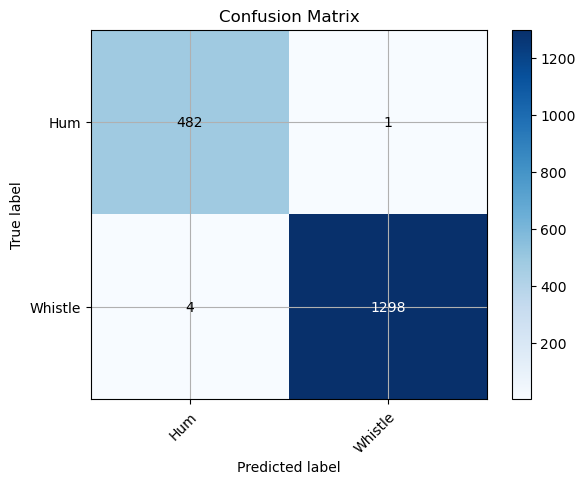

In [38]:
plot_confusion_matrix(cm)

**Model 1: SVM**

In [39]:
X=scaled_data.iloc[:,0:191].values # all the features
y=scaled_data['song_lable'].values

In [40]:
scaled_data['song_lable'].unique()

array([1, 3, 2, 0, 5, 6, 4, 7], dtype=int64)

In [41]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,test_size=0.1)

#checking the data split 
print('Size of training set:', X_train.shape, y_train.shape)
print('Size of validation set:', X_val.shape, y_val.shape)
print('Size of testing set:', X_test.shape, y_test.shape)

Size of training set: (4627, 191) (4627,)
Size of validation set: (1785, 191) (1785,)
Size of testing set: (199, 191) (199,)


In [42]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

In [43]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5178301275124271
Validation  Accuracy 0.4061624649859944
The support vectors are (4398, 191)


**Grid Search for SVM / Hypertuning**

In [44]:
param_grid = {
    'C': [0.1,1, 10, 100, 1000], 
    'gamma': [1,0.1,0.01,0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

In [45]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.8s
[CV] END .....................C=0.1, gamma=1, k

[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   1.8s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   1.8s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   1.8s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   1.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   1.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   2.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   1.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   1.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   1.9s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   1.8s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   1.8s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   1.8s
[CV] END ...................

[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   2.2s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   2.2s
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time=   2.0s
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time=   1.8s
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time=   1.8s
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time=   1.8s
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time=   1.9s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   2.4s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   2.4s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   2.4s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time=   2.3s
[CV] END ...................

[CV] END .......................C=1000, gamma=1, kernel=poly; total time=   1.9s
[CV] END .......................C=1000, gamma=1, kernel=poly; total time=   2.0s
[CV] END .......................C=1000, gamma=1, kernel=poly; total time=   1.9s
[CV] END .......................C=1000, gamma=1, kernel=poly; total time=   1.9s
[CV] END .......................C=1000, gamma=1, kernel=poly; total time=   2.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   2.3s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   2.3s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [46]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.1)


In [47]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.529711 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [48]:
grid_predictions = grid.predict(X_val)
from sklearn.metrics import classification_report, confusion_matrix  

print(classification_report(y_val,grid_predictions))

              precision    recall  f1-score   support

           0       0.41      0.70      0.51       234
           1       0.68      0.57      0.62       237
           2       0.64      0.57      0.60       230
           3       0.52      0.49      0.51       217
           4       0.69      0.57      0.63       209
           5       0.64      0.56      0.60       232
           6       0.61      0.60      0.60       211
           7       0.63      0.55      0.59       215

    accuracy                           0.58      1785
   macro avg       0.60      0.58      0.58      1785
weighted avg       0.60      0.58      0.58      1785



**Validation Accuracy of SVM Model**

In [49]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5178301275124271
Validation  Accuracy 0.4061624649859944
The support vectors are (4398, 191)


# **Testing Accuracy of SVM Model**

In [50]:
y_tpred = model.predict(X_test)  # Most prevalent prediction
cm = confusion_matrix(y_test, y_tpred)

#ploting confusing matrix on testing set
# plot_confusion_matrix(cm)

In [51]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Testing Accuracy', np.mean(y_tpred==y_test))

Training Accuracy 0.5178301275124271
Testing Accuracy 0.4020100502512563


**FineTuning Testing SVM Model**

In [52]:
grid_predictions = grid.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
# print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.33      0.74      0.46        19
           1       0.50      0.43      0.46        21
           2       0.67      0.50      0.57        24
           3       0.60      0.57      0.59        21
           4       0.83      0.64      0.72        39
           5       0.73      0.66      0.69        29
           6       0.52      0.55      0.53        22
           7       0.55      0.50      0.52        24

    accuracy                           0.58       199
   macro avg       0.59      0.57      0.57       199
weighted avg       0.62      0.58      0.59       199



**Confusion Matrix SVM Validation Data**

In [53]:
y_pred = model.predict(X_val) # predicted percentages
cm = confusion_matrix(y_val, y_pred)

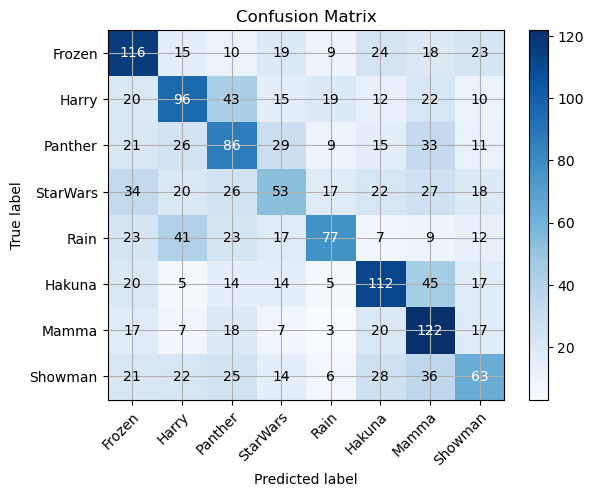

In [54]:
classes= ['Frozen', 'Harry', 'Panther', 'StarWars', 'Rain','Hakuna', 'Mamma', 'Showman']
n_classes=len(classes)

plot_confusion_matrix(cm)

**Confusion Matrix Testing Data SVM**

In [55]:
y_pred = model.predict(X_test) # predicted percentages
cm = confusion_matrix(y_test, y_pred)

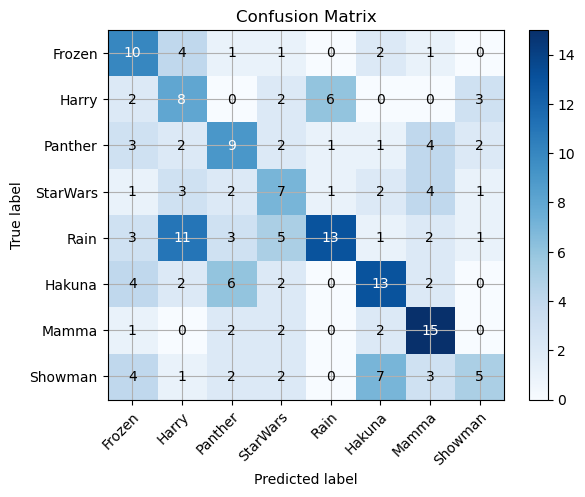

In [56]:
classes= ['Frozen', 'Harry', 'Panther', 'StarWars', 'Rain','Hakuna', 'Mamma', 'Showman']
n_classes=len(classes)

plot_confusion_matrix(cm)

**Model 2: CNN**

In [57]:
### Training / Fitting / Optimizing Model ##### 

test_size = 0.2
epochs    = 30
batch_size= 16
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [58]:
classes= ['Frozen', 'Harry', 'Panther', 'StarWars', 'Rain','Hakuna', 'Mamma', 'Showman']
n_classes=len(classes)

In [59]:
model2 = Sequential()
model2.add(Dense(256, activation='relu',  input_dim=X_train.shape[1]))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(n_classes, activation='softmax')) # sigmoid

model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [67]:
history = None
history = model2.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
#                         shuffle=True,
                        verbose=2)

Epoch 1/30
290/290 - 1s - loss: 1.9050 - accuracy: 0.2818 - val_loss: 1.7896 - val_accuracy: 0.3569 - 1s/epoch - 4ms/step
Epoch 2/30
290/290 - 0s - loss: 1.6250 - accuracy: 0.4007 - val_loss: 1.6957 - val_accuracy: 0.4022 - 457ms/epoch - 2ms/step
Epoch 3/30
290/290 - 0s - loss: 1.4995 - accuracy: 0.4528 - val_loss: 1.6869 - val_accuracy: 0.4129 - 451ms/epoch - 2ms/step
Epoch 4/30
290/290 - 0s - loss: 1.3656 - accuracy: 0.5124 - val_loss: 1.6074 - val_accuracy: 0.4303 - 443ms/epoch - 2ms/step
Epoch 5/30
290/290 - 0s - loss: 1.2390 - accuracy: 0.5526 - val_loss: 1.6883 - val_accuracy: 0.4314 - 449ms/epoch - 2ms/step
Epoch 6/30
290/290 - 0s - loss: 1.1522 - accuracy: 0.5997 - val_loss: 1.7112 - val_accuracy: 0.4336 - 438ms/epoch - 2ms/step
Epoch 7/30
290/290 - 0s - loss: 1.0648 - accuracy: 0.6296 - val_loss: 1.6872 - val_accuracy: 0.4515 - 442ms/epoch - 2ms/step
Epoch 8/30
290/290 - 0s - loss: 0.9494 - accuracy: 0.6644 - val_loss: 1.7244 - val_accuracy: 0.4706 - 466ms/epoch - 2ms/step
Epo

In [63]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               49152     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 90824 (354.78 KB)
Trainable params: 90824 (354.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Accuracy of Validation Data CNN Model**

In [68]:
score_train = model2.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score_train[1])
print("Training Cross Entropy: %.2f" % score_train[0])

score_test = model2.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy: ", score_test[1])
print("Validation Cross Entropy: %.2f" % score_test[0])

Training Accuracy:  0.9842230677604675
Training Cross Entropy: 0.07
Validation Accuracy:  0.5428571701049805
Validation Cross Entropy: 3.40


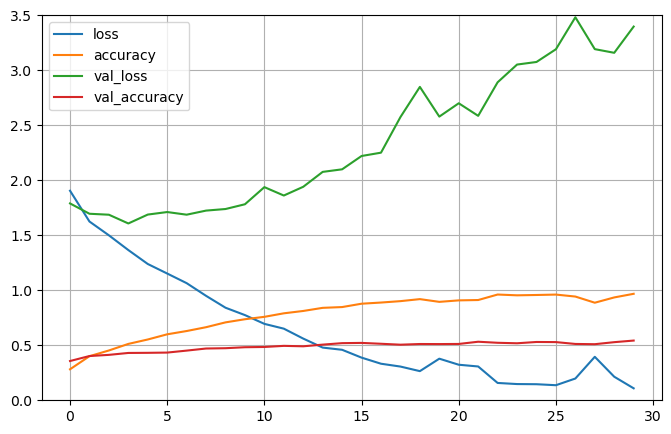

In [92]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)

plt.show()

**Confusion Matrix for Validation Data CNN Model**

In [70]:
y_pred_percentages = model2.predict(X_val) # predicted percentages
y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction
cm = confusion_matrix(y_val, y_pred)

56/56 [==============================] - 0s 1ms/step


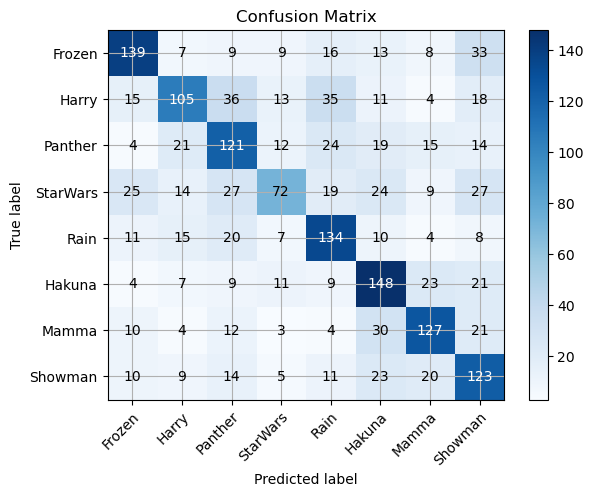

In [71]:
plot_confusion_matrix(cm)

**Testing CNN & Confusion Matrix for Testing Data**

In [72]:
print('Size of testing set:', X_test.shape, y_test.shape)

Size of testing set: (199, 191) (199,)


In [73]:
score_test = model2.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

Testing Accuracy:  0.552763819694519
Testing Cross Entropy: 3.19


7/7 [==============================] - 0s 1ms/step


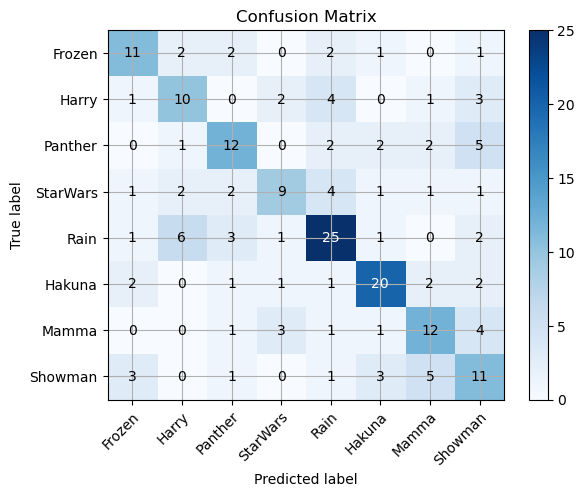

In [74]:
y_pred_percentages = model2.predict(X_test) # predicted percentages
y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction
cm = confusion_matrix(y_test, y_pred)

#ploting confusing matrix on testing set
plot_confusion_matrix(cm)

**Hypertuning CNN Model**

pip install tensorflow==2.14.1 --user

In [75]:
from scikeras.wrappers import KerasClassifier

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV

pip install scikeras

In [77]:
def create_model(optimizer = 'adam'):
    model3 = Sequential()
    model3.add(Input(shape = (X_train.shape[1],)))
    model3.add(Dense(256, activation='relu'))
    model3.add(Dense(128, activation='relu'))
    model3.add(Dense(64, activation='relu'))
    model3.add(Dense(n_classes, activation='softmax')) # sigmoid

    model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model3

In [78]:
model4 = KerasClassifier(model = create_model)
parameters = {'batch_size': [30, 50, 70],
          'epochs': [40,60,80],
          'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = model4,
                       param_grid = parameters,
                       refit = True, verbose = 2,
                          error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/40
124/124 [==============================] - 1s 2ms/step - loss: 1.9761 - accuracy: 0.2653
Epoch 2/40
124/124 [==============================] - 0s 2ms/step - loss: 1.6970 - accuracy: 0.3861
Epoch 3/40
124/124 [==============================] - 0s 2ms/step - loss: 1.5369 - accuracy: 0.4523
Epoch 4/40
124/124 [==============================] - 0s 2ms/step - loss: 1.4233 - accuracy: 0.4961
Epoch 5/40
124/124 [==============================] - 0s 1ms/step - loss: 1.2867 - accuracy: 0.5353
Epoch 6/40
124/124 [==============================] - 0s 1ms/step - loss: 1.1879 - accuracy: 0.5836
Epoch 7/40
124/124 [==============================] - 0s 2ms/step - loss: 1.0958 - accuracy: 0.6228
Epoch 8/40
124/124 [==============================] - 0s 2ms/step - loss: 0.9928 - accuracy: 0.6474
Epoch 9/40
124/124 [==============================] - 0s 2ms/step - loss: 0.9465 - accuracy: 0.6839
Epoch 10/40
124/124 [==================

124/124 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9908
Epoch 39/40
124/124 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9935
Epoch 40/40
31/31 [==============================] - 0s 932us/step
[CV] END ...........batch_size=30, epochs=40, optimizer=adam; total time=   8.7s
Epoch 1/40
124/124 [==============================] - 1s 2ms/step - loss: 1.9623 - accuracy: 0.2585
Epoch 2/40
124/124 [==============================] - 0s 2ms/step - loss: 1.6673 - accuracy: 0.3941
Epoch 3/40
124/124 [==============================] - 0s 2ms/step - loss: 1.5189 - accuracy: 0.4489
Epoch 4/40
124/124 [==============================] - 0s 1ms/step - loss: 1.4037 - accuracy: 0.4916
Epoch 5/40
124/124 [==============================] - 0s 2ms/step - loss: 1.2982 - accuracy: 0.5262
Epoch 6/40
124/124 [==============================] - 0s 2ms/step - loss: 1.1919 - accuracy: 0.5775
Epoch 7/40
124/124 [==============================] - 0s 2ms/s

124/124 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9522
Epoch 35/40
124/124 [==============================] - 0s 2ms/step - loss: 0.1282 - accuracy: 0.9689
Epoch 36/40
124/124 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9943
Epoch 37/40
124/124 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9930
Epoch 38/40
124/124 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9976
Epoch 39/40
124/124 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9973
Epoch 40/40
31/31 [==============================] - 0s 1ms/step
[CV] END ........batch_size=30, epochs=40, optimizer=rmsprop; total time=  11.9s
Epoch 1/40
124/124 [==============================] - 1s 3ms/step - loss: 1.9497 - accuracy: 0.2761
Epoch 2/40
124/124 [==============================] - 0s 3ms/step - loss: 1.6610 - accuracy: 0.4046
Epoch 3/40
124/124 [==============================] - 0s 2ms

124/124 [==============================] - 0s 2ms/step - loss: 0.8821 - accuracy: 0.7041
Epoch 11/60
124/124 [==============================] - 0s 2ms/step - loss: 0.7869 - accuracy: 0.7320
Epoch 12/60
124/124 [==============================] - 0s 2ms/step - loss: 0.6737 - accuracy: 0.7811
Epoch 13/60
124/124 [==============================] - 0s 2ms/step - loss: 0.6072 - accuracy: 0.8041
Epoch 14/60
124/124 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.8222
Epoch 15/60
124/124 [==============================] - 0s 2ms/step - loss: 0.4674 - accuracy: 0.8511
Epoch 16/60
124/124 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8692
Epoch 17/60
124/124 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8838
Epoch 18/60
124/124 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.9041
Epoch 19/60
124/124 [==============================] - 0s 2ms/step - loss: 0.3819 - accuracy: 0.8914
Ep

Epoch 30/60
124/124 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9749
Epoch 31/60
124/124 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.9760
Epoch 32/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9754
Epoch 33/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9851
Epoch 34/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9951
Epoch 35/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9938
Epoch 36/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9970
Epoch 37/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9962
Epoch 38/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9968
Epoch 39/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0177 - accurac

124/124 [==============================] - 0s 2ms/step - loss: 1.0956 - accuracy: 0.6169
Epoch 8/60
124/124 [==============================] - 0s 2ms/step - loss: 1.0013 - accuracy: 0.6498
Epoch 9/60
124/124 [==============================] - 0s 2ms/step - loss: 0.9306 - accuracy: 0.6828
Epoch 10/60
124/124 [==============================] - 0s 2ms/step - loss: 0.8352 - accuracy: 0.7233
Epoch 11/60
124/124 [==============================] - 0s 2ms/step - loss: 0.7381 - accuracy: 0.7539
Epoch 12/60
124/124 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.7836
Epoch 13/60
124/124 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.7860
Epoch 14/60
124/124 [==============================] - 0s 2ms/step - loss: 0.5736 - accuracy: 0.8182
Epoch 15/60
124/124 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.8471
Epoch 16/60
124/124 [==============================] - 0s 2ms/step - loss: 0.4112 - accuracy: 0.8749
Epoc

124/124 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9849
Epoch 28/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9843
Epoch 29/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9878
Epoch 30/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0577 - accuracy: 0.9903
Epoch 31/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.9916
Epoch 32/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9843
Epoch 33/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9792
Epoch 34/60
124/124 [==============================] - 0s 2ms/step - loss: 0.2286 - accuracy: 0.9360
Epoch 35/60
124/124 [==============================] - 0s 2ms/step - loss: 0.2366 - accuracy: 0.9249
Epoch 36/60
124/124 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9551
Ep

Epoch 47/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9941
Epoch 48/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9954
Epoch 49/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9970
Epoch 50/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9978
Epoch 51/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9976
Epoch 52/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9989
Epoch 53/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9989
Epoch 54/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9986
Epoch 55/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9989
Epoch 56/60
124/124 [==============================] - 0s 2ms/step - loss: 0.0056 - accurac

124/124 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9724
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9814
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9832
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9784
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9727
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0972 - accuracy: 0.9735
Epoch 31/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0840 - accuracy: 0.9776
Epoch 32/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.9397
Epoch 33/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9235
Epoch 34/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9522
Ep

Epoch 25/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9776
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0920 - accuracy: 0.9789
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9795
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1174 - accuracy: 0.9714
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9735
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1108 - accuracy: 0.9719
Epoch 31/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1066 - accuracy: 0.9730
Epoch 32/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0851 - accuracy: 0.9770
Epoch 33/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9835
Epoch 34/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0988 - accurac

Epoch 24/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.9308
Epoch 25/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9471
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.9673
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9797
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0805 - accuracy: 0.9806
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9827
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9884
Epoch 31/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9868
Epoch 32/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1426 - accuracy: 0.9635
Epoch 33/80
124/124 [==============================] - 0s 2ms/step - loss: 0.3194 - accurac

Epoch 23/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9597
Epoch 24/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.9500
Epoch 25/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.9533
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2110 - accuracy: 0.9562
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.9611
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9592
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9424
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.9397
Epoch 31/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2078 - accuracy: 0.9627
Epoch 32/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0979 - accurac

Epoch 22/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2378 - accuracy: 0.9422
Epoch 23/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.9568
Epoch 24/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.9454
Epoch 25/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.9444
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9635
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1210 - accuracy: 0.9706
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1113 - accuracy: 0.9733
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.9806
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9865
Epoch 31/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0552 - accurac

Epoch 21/80
124/124 [==============================] - 0s 3ms/step - loss: 0.2348 - accuracy: 0.9341
Epoch 22/80
124/124 [==============================] - 0s 3ms/step - loss: 0.3763 - accuracy: 0.8930
Epoch 23/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.9263
Epoch 24/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.9211
Epoch 25/80
124/124 [==============================] - 0s 2ms/step - loss: 0.2969 - accuracy: 0.9349
Epoch 26/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1856 - accuracy: 0.9579
Epoch 27/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9754
Epoch 28/80
124/124 [==============================] - 0s 2ms/step - loss: 0.1066 - accuracy: 0.9797
Epoch 29/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0848 - accuracy: 0.9830
Epoch 30/80
124/124 [==============================] - 0s 2ms/step - loss: 0.0693 - accurac

75/75 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.8795
Epoch 22/40
75/75 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.9098
Epoch 23/40
75/75 [==============================] - 0s 2ms/step - loss: 0.3652 - accuracy: 0.8984
Epoch 24/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.9379
Epoch 25/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2046 - accuracy: 0.9516
Epoch 26/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9395
Epoch 27/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9627
Epoch 28/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9711
Epoch 29/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1209 - accuracy: 0.9760
Epoch 30/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1059 - accuracy: 0.9803
Epoch 31/40
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.9200
Epoch 22/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.9281
Epoch 23/40
75/75 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.9130
Epoch 24/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.9381
Epoch 25/40
75/75 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9379
Epoch 26/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9589
Epoch 27/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9705
Epoch 28/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9765
Epoch 29/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9711
Epoch 30/40
75/75 [==============================] - 0s 2ms/step - loss: 0.1675 - accuracy: 0.9557
Epoch 31/40
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.3862 - accuracy: 0.9092
Epoch 22/60
75/75 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.9179
Epoch 23/60
75/75 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.9406
Epoch 24/60
75/75 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.9406
Epoch 25/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.9562
Epoch 26/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1784 - accuracy: 0.9573
Epoch 27/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1382 - accuracy: 0.9714
Epoch 28/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1137 - accuracy: 0.9768
Epoch 29/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.9733
Epoch 30/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1310 - accuracy: 0.9689
Epoch 31/60
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 1.7074 - accuracy: 0.3784
Epoch 3/60
75/75 [==============================] - 0s 2ms/step - loss: 1.5473 - accuracy: 0.4446
Epoch 4/60
75/75 [==============================] - 0s 2ms/step - loss: 1.4528 - accuracy: 0.4808
Epoch 5/60
75/75 [==============================] - 0s 2ms/step - loss: 1.3468 - accuracy: 0.5243
Epoch 6/60
75/75 [==============================] - 0s 2ms/step - loss: 1.2504 - accuracy: 0.5637
Epoch 7/60
75/75 [==============================] - 0s 2ms/step - loss: 1.1657 - accuracy: 0.5910
Epoch 8/60
75/75 [==============================] - 0s 2ms/step - loss: 1.0705 - accuracy: 0.6305
Epoch 9/60
75/75 [==============================] - 0s 2ms/step - loss: 1.0546 - accuracy: 0.6413
Epoch 10/60
75/75 [==============================] - 0s 2ms/step - loss: 1.0307 - accuracy: 0.6686
Epoch 11/60
75/75 [==============================] - 0s 2ms/step - loss: 0.8910 - accuracy: 0.7072
Epoch 12/60
75/75 [==========

75/75 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9870
Epoch 45/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9959
Epoch 46/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9968
Epoch 47/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9973
Epoch 48/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9976
Epoch 49/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9946
Epoch 50/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9957
Epoch 51/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0586 - accuracy: 0.9819
Epoch 52/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0482 - accuracy: 0.9876
Epoch 53/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9938
Epoch 54/60
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.9489
Epoch 26/60
75/75 [==============================] - 0s 2ms/step - loss: 0.2040 - accuracy: 0.9468
Epoch 27/60
75/75 [==============================] - 0s 2ms/step - loss: 0.2241 - accuracy: 0.9400
Epoch 28/60
75/75 [==============================] - 0s 2ms/step - loss: 0.2064 - accuracy: 0.9441
Epoch 29/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.9652
Epoch 30/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9762
Epoch 31/60
75/75 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.9803
Epoch 32/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.9760
Epoch 33/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.9757
Epoch 34/60
75/75 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9773
Epoch 35/60
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9976
Epoch 68/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9995
Epoch 69/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9973
Epoch 70/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9981
Epoch 71/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9981
Epoch 72/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.9970
Epoch 73/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9984
Epoch 74/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9986
Epoch 75/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.9978
Epoch 76/80
75/75 [==============================] - 0s 2ms/step - loss: 0.1082 - accuracy: 0.9649
Epoch 77/80
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9968
Epoch 70/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9978
Epoch 71/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9970
Epoch 72/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9962
Epoch 73/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9946
Epoch 74/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9865
Epoch 75/80
75/75 [==============================] - 0s 2ms/step - loss: 0.1179 - accuracy: 0.9630
Epoch 76/80
75/75 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9357
Epoch 77/80
75/75 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9460
Epoch 78/80
75/75 [==============================] - 0s 2ms/step - loss: 0.1145 - accuracy: 0.9689
Epoch 79/80
75/75 [===

75/75 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9981
Epoch 72/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.9986
Epoch 73/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9986
Epoch 74/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9978
Epoch 75/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9946
Epoch 76/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.9692
Epoch 77/80
75/75 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.8390
Epoch 78/80
75/75 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.9217
Epoch 79/80
75/75 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9454
Epoch 80/80
19/19 [==============================] - 0s 1ms/step
[CV] END ...........batch_size=50, epochs=80, optimizer=

75/75 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9878
Epoch 74/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9970
Epoch 75/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9986
Epoch 76/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9986
Epoch 77/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9976
Epoch 78/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9984
Epoch 79/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9984
Epoch 80/80
19/19 [==============================] - 0s 1ms/step
[CV] END ........batch_size=50, epochs=80, optimizer=rmsprop; total time=  13.9s
Epoch 1/80
75/75 [==============================] - 1s 2ms/step - loss: 1.9919 - accuracy: 0.2469
Epoch 2/80
75/75 [==============================] - 0s 2ms/step - loss: 1.6

75/75 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9986
Epoch 76/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9986
Epoch 77/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9992
Epoch 78/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9989
Epoch 79/80
75/75 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9992
Epoch 80/80
19/19 [==============================] - 0s 1ms/step
[CV] END ........batch_size=50, epochs=80, optimizer=rmsprop; total time=  11.6s
Epoch 1/80
75/75 [==============================] - 1s 2ms/step - loss: 2.0011 - accuracy: 0.2453
Epoch 2/80
75/75 [==============================] - 0s 2ms/step - loss: 1.7128 - accuracy: 0.3782
Epoch 3/80
75/75 [==============================] - 0s 2ms/step - loss: 1.5579 - accuracy: 0.4287
Epoch 4/80
75/75 [==============================] - 0s 2ms/step - loss: 1.444

53/53 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.9557
Epoch 37/40
53/53 [==============================] - 0s 2ms/step - loss: 0.1575 - accuracy: 0.9665
Epoch 38/40
53/53 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.9711
Epoch 39/40
53/53 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9687
Epoch 40/40
14/14 [==============================] - 0s 1ms/step
[CV] END ...........batch_size=70, epochs=40, optimizer=adam; total time=   4.6s
Epoch 1/40
53/53 [==============================] - 1s 2ms/step - loss: 1.9967 - accuracy: 0.2331
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 1.7247 - accuracy: 0.3784
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 1.5584 - accuracy: 0.4417
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 1.4324 - accuracy: 0.4978
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 1.3490

53/53 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9932
Epoch 37/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.9943
Epoch 38/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9951
Epoch 39/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 0.9932
Epoch 40/40
14/14 [==============================] - 0s 1ms/step
[CV] END ........batch_size=70, epochs=40, optimizer=rmsprop; total time=   5.2s
Epoch 1/40
53/53 [==============================] - 1s 2ms/step - loss: 2.0004 - accuracy: 0.2370
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 1.7368 - accuracy: 0.3680
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 1.5939 - accuracy: 0.4202
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 1.4653 - accuracy: 0.4758
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 1.3469

53/53 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9943
Epoch 37/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9968
Epoch 38/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0347 - accuracy: 0.9959
Epoch 39/40
53/53 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9949
Epoch 40/40
14/14 [==============================] - 0s 1ms/step
[CV] END ........batch_size=70, epochs=40, optimizer=rmsprop; total time=   5.5s
Epoch 1/60
53/53 [==============================] - 1s 2ms/step - loss: 2.0078 - accuracy: 0.2367
Epoch 2/60
53/53 [==============================] - 0s 2ms/step - loss: 1.7493 - accuracy: 0.3545
Epoch 3/60
53/53 [==============================] - 0s 2ms/step - loss: 1.5957 - accuracy: 0.4258
Epoch 4/60
53/53 [==============================] - 0s 2ms/step - loss: 1.4662 - accuracy: 0.4734
Epoch 5/60
53/53 [==============================] - 0s 2ms/step - loss: 1.3498

53/53 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9943
Epoch 38/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9946
Epoch 39/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9965
Epoch 40/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9978
Epoch 41/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9978
Epoch 42/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9932
Epoch 43/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9951
Epoch 44/60
53/53 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9900
Epoch 45/60
53/53 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.9471
Epoch 46/60
53/53 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.8836
Epoch 47/60
53/53 [===

53/53 [==============================] - 0s 2ms/step - loss: 0.4960 - accuracy: 0.8733
Epoch 19/60
53/53 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8998
Epoch 20/60
53/53 [==============================] - 0s 2ms/step - loss: 0.3772 - accuracy: 0.9006
Epoch 21/60
53/53 [==============================] - 0s 2ms/step - loss: 0.3428 - accuracy: 0.9138
Epoch 22/60
53/53 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.9306
Epoch 23/60
53/53 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.9451
Epoch 24/60
53/53 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9524
Epoch 25/60
53/53 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9581
Epoch 26/60
53/53 [==============================] - 0s 2ms/step - loss: 0.1443 - accuracy: 0.9722
Epoch 27/60
53/53 [==============================] - 0s 2ms/step - loss: 0.1174 - accuracy: 0.9795
Epoch 28/60
53/53 [===

14/14 [==============================] - 0s 1ms/step
[CV] END ........batch_size=70, epochs=60, optimizer=rmsprop; total time=   8.0s
Epoch 1/60
53/53 [==============================] - 1s 2ms/step - loss: 2.0106 - accuracy: 0.2410
Epoch 2/60
53/53 [==============================] - 0s 2ms/step - loss: 1.7220 - accuracy: 0.3679
Epoch 3/60
53/53 [==============================] - 0s 2ms/step - loss: 1.5648 - accuracy: 0.4333
Epoch 4/60
53/53 [==============================] - 0s 2ms/step - loss: 1.4482 - accuracy: 0.4887
Epoch 5/60
53/53 [==============================] - 0s 2ms/step - loss: 1.3436 - accuracy: 0.5308
Epoch 6/60
53/53 [==============================] - 0s 2ms/step - loss: 1.2389 - accuracy: 0.5748
Epoch 7/60
53/53 [==============================] - 0s 2ms/step - loss: 1.1503 - accuracy: 0.6116
Epoch 8/60
53/53 [==============================] - 0s 2ms/step - loss: 1.0496 - accuracy: 0.6434
Epoch 9/60
53/53 [==============================] - 0s 2ms/step - loss: 0.9808 - a

53/53 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9924
Epoch 42/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9976
Epoch 43/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9970
Epoch 44/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9989
Epoch 45/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9981
Epoch 46/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9976
Epoch 47/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9959
Epoch 48/80
53/53 [==============================] - 0s 3ms/step - loss: 0.0331 - accuracy: 0.9935
Epoch 49/80
53/53 [==============================] - 0s 3ms/step - loss: 0.0493 - accuracy: 0.9903
Epoch 50/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9887
Epoch 51/80
53/53 [===

53/53 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9981
Epoch 44/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9968
Epoch 45/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9946
Epoch 46/80
53/53 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9571
Epoch 47/80
53/53 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.8593
Epoch 48/80
53/53 [==============================] - 0s 2ms/step - loss: 0.4548 - accuracy: 0.9033
Epoch 49/80
53/53 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.9538
Epoch 50/80
53/53 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9765
Epoch 51/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9908
Epoch 52/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9951
Epoch 53/80
53/53 [===

53/53 [==============================] - 0s 2ms/step - loss: 0.0569 - accuracy: 0.9905
Epoch 46/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9862
Epoch 47/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0564 - accuracy: 0.9905
Epoch 48/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9911
Epoch 49/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9914
Epoch 50/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9930
Epoch 51/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9962
Epoch 52/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9957
Epoch 53/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9959
Epoch 54/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9965
Epoch 55/80
53/53 [===

53/53 [==============================] - 0s 2ms/step - loss: 0.1066 - accuracy: 0.9795
Epoch 48/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9927
Epoch 49/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9970
Epoch 50/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9976
Epoch 51/80
53/53 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9978
Epoch 52/80
53/53 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9973
Epoch 53/80
53/53 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9962
Epoch 54/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9973
Epoch 55/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9968
Epoch 56/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9959
Epoch 57/80
53/53 [===

53/53 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9973
Epoch 50/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9981
Epoch 51/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9981
Epoch 52/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9970
Epoch 53/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9984
Epoch 54/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9976
Epoch 55/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9968
Epoch 56/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.9981
Epoch 57/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9959
Epoch 58/80
53/53 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9914
Epoch 59/80
53/53 [===

67/67 [==============================] - 0s 2ms/step - loss: 0.2738 - accuracy: 0.9300
Epoch 52/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0954 - accuracy: 0.9728
Epoch 53/80
67/67 [==============================] - 0s 2ms/step - loss: 0.1180 - accuracy: 0.9719
Epoch 54/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9922
Epoch 55/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9963
Epoch 56/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9976
Epoch 57/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 0.9983
Epoch 58/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9972
Epoch 59/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9955
Epoch 60/80
67/67 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9970
Epoch 61/80
67/67 [===

GridSearchCV(error_score='raise',
             estimator=KerasClassifier(model=<function create_model at 0x000001EB34902020>),
             param_grid={'batch_size': [30, 50, 70], 'epochs': [40, 60, 80],
                         'optimizer': ['adam', 'rmsprop']},
             verbose=2)

!python -c "import tensorflow as tf; print(tf.__version__)"

In [79]:
print(grid_search.best_estimator_)

KerasClassifier(
	model=<function create_model at 0x000001EB34902020>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=70
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=80
	class_weight=None
)


In [80]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.502914 using {'batch_size': 70, 'epochs': 80, 'optimizer': 'adam'}


**Validation Result HyperTuning**

In [81]:
grid_predictions = grid_search.predict(X_val)
print(classification_report(y_val,grid_predictions))

26/26 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       234
           1       0.62      0.44      0.52       237
           2       0.47      0.48      0.48       230
           3       0.39      0.45      0.42       217
           4       0.48      0.65      0.55       209
           5       0.57      0.58      0.58       232
           6       0.56      0.61      0.58       211
           7       0.55      0.47      0.50       215

    accuracy                           0.53      1785
   macro avg       0.54      0.53      0.53      1785
weighted avg       0.54      0.53      0.53      1785



**Testing Result HyperTuning**

In [82]:
grid_predictions = grid_search.predict(X_test)
print(classification_report(y_test,grid_predictions))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.63      0.71        19
           1       0.33      0.29      0.31        21
           2       0.65      0.46      0.54        24
           3       0.43      0.48      0.45        21
           4       0.56      0.72      0.63        39
           5       0.53      0.59      0.56        29
           6       0.46      0.55      0.50        22
           7       0.61      0.46      0.52        24

    accuracy                           0.54       199
   macro avg       0.55      0.52      0.53       199
weighted avg       0.55      0.54      0.54       199



**Dataset Explanation**

**Visualisasi wave form dari salah satu file pada folder Frozen**

In [83]:
import librosa
audio_path = 'C:\\Facultate\\Anul_IV\\Sem_II\\ProcesareaSemnaluluiVocal_(PSV)\\Proiect\\Data\\MLEndHWD_Frozen_Audio_Files\\5798.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [84]:
import IPython.display as ipd
ipd.Audio(audio_path)

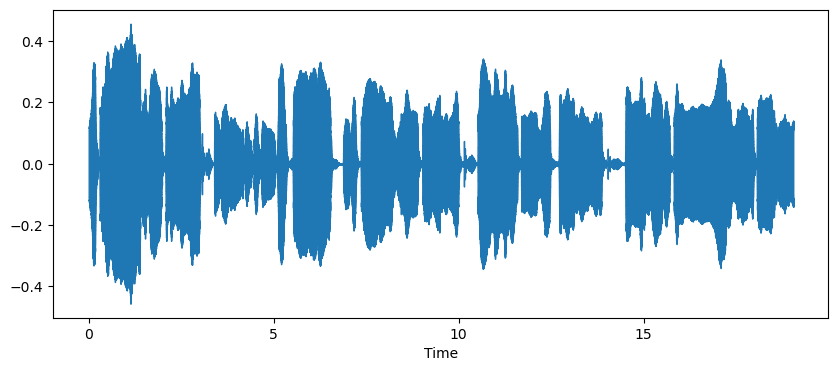

In [85]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display 
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x, sr=sr)

**Mel Spectogram**

(128, 821)


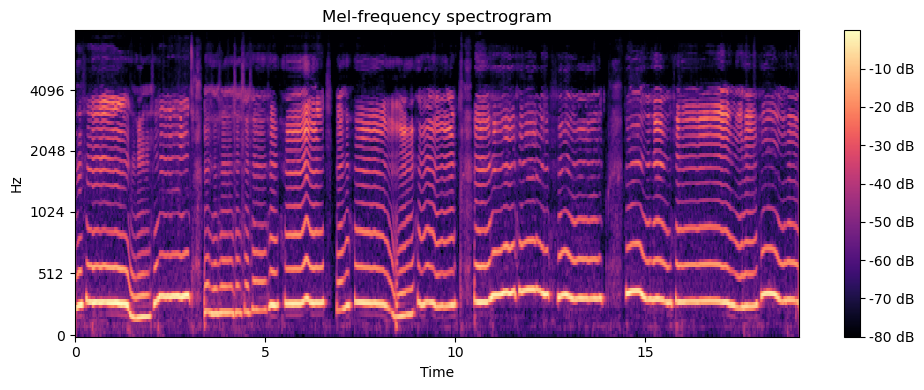

In [86]:
S = librosa.feature.melspectrogram(y=x, sr=sr)

import numpy as np

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

Spectral Contrast

(7, 821)


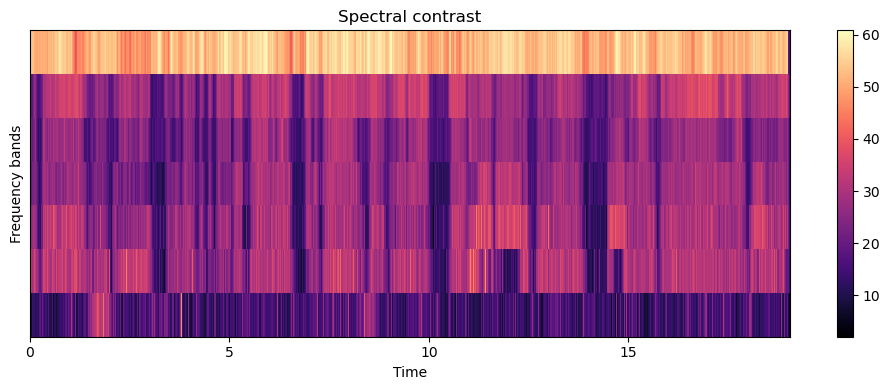

In [87]:
S = np.abs(librosa.stft(x))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
print(contrast.shape)

plt.figure(figsize=(10,4))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')
plt.tight_layout()
plt.show()

**MFCC**

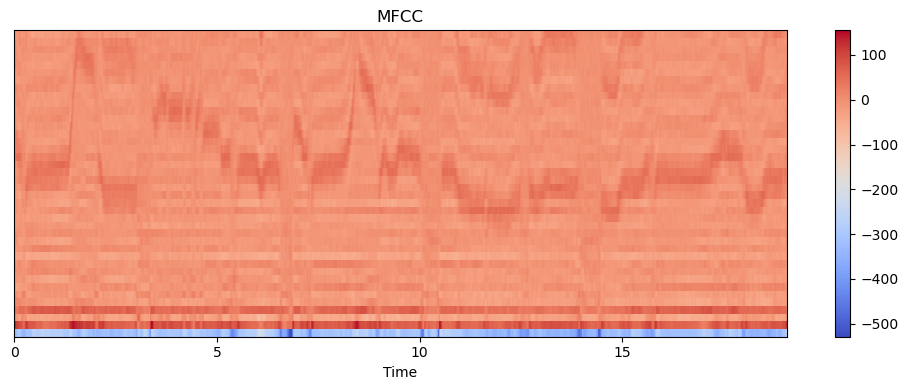

In [88]:
mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [89]:
scaled_data[scaled_data['interpret_lable']==True].describe() #for humming files
# 0-39: mfcc features
# 40-51: chroma
# 52-179: mel
# 180-186: contrast
# 187: power, 188: pitch mean, 189: pitch std, 190: voice frame

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,song_lable
count,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,...,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000
mean,-0.015429,0.402847,0.266017,0.364866,0.209550,-0.146095,-0.277663,-0.160288,-0.067440,-0.081739,...,0.481055,-0.272155,-0.109257,0.247771,0.018852,0.003406,-0.482216,0.124583,0.263884,3.501040
std,1.011682,0.750323,0.903428,0.729907,0.946571,0.966481,0.901387,0.922478,1.012069,0.987080,...,0.693347,0.759485,0.882236,0.957609,0.962213,0.956389,0.692012,0.987330,0.744834,2.280793
min,-3.654328,-2.132959,-3.453201,-2.054171,-3.451780,-3.551893,-3.229937,-3.240439,-3.825260,-3.960904,...,-1.645128,-1.975820,-2.018362,-1.684194,-1.689455,-0.984052,-1.724462,-2.042983,-4.363603,0.000000
25%,-0.683886,-0.103639,-0.295071,-0.096876,-0.364556,-0.761875,-0.922772,-0.758634,-0.719060,-0.723723,...,0.003777,-0.802663,-0.773124,-0.433039,-0.701628,-0.441912,-1.029678,-0.639027,-0.180849,2.000000
50%,-0.021710,0.437692,0.309395,0.407082,0.283399,-0.044813,-0.236872,-0.146541,-0.035527,-0.068773,...,0.444949,-0.357599,-0.191284,0.129833,-0.084742,-0.163999,-0.647436,-0.036323,0.334448,4.000000
75%,0.614979,0.921658,0.871999,0.865811,0.855843,0.523364,0.381878,0.465685,0.634552,0.635779,...,0.909201,0.167569,0.421974,0.779748,0.559822,0.206164,0.083018,0.805582,0.803594,5.000000
max,5.296569,3.284281,2.956832,2.753076,2.988633,3.072087,2.621633,3.297807,2.767944,2.961534,...,3.400085,3.483912,3.620226,4.759755,7.194919,16.386786,1.615780,4.381369,2.077571,7.000000


In [90]:
scaled_data[scaled_data['interpret_lable']==False].describe() #for whistling files
# 0-39: mfcc features
# 40-51: chroma
# 52-179: mel
# 180-186: contrast
# 187: power, 188: pitch mean, 189: pitch std, 190: voice frame

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,song_lable
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,...,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000
mean,0.041206,-1.075898,-0.710461,-0.974461,-0.559653,0.390181,0.741566,0.428086,0.180114,0.218305,...,-1.284773,0.726854,0.291797,-0.661732,-0.050348,-0.009097,1.287872,-0.332729,-0.704766,3.465852
std,0.967467,0.759478,0.893351,0.971370,0.921002,0.983794,0.863600,1.071105,0.944256,1.002081,...,0.344208,1.185401,1.214998,0.787804,1.093490,1.108578,0.335346,0.957151,1.227822,2.284507
min,-2.846971,-3.499285,-5.074111,-3.275274,-3.490471,-3.510944,-2.672919,-3.158655,-3.612231,-2.854635,...,-1.756230,-1.927718,-1.978320,-1.746922,-1.631542,-0.980892,-2.643836,-2.323162,-5.442290,0.000000
25%,-0.578482,-1.625947,-1.233714,-1.595922,-1.196678,-0.237354,0.233487,-0.218052,-0.464410,-0.473265,...,-1.516548,0.051434,-0.615536,-1.114801,-0.872011,-0.601517,1.221956,-0.727919,-1.213134,1.000000
50%,0.047134,-1.113719,-0.708476,-1.083138,-0.589123,0.383688,0.777221,0.517631,0.171282,0.168523,...,-1.355948,0.951517,0.048626,-0.817240,-0.344337,-0.341640,1.321595,-0.434603,-0.503586,3.000000
75%,0.635275,-0.542627,-0.078068,-0.569360,0.006799,0.965995,1.329515,1.136685,0.826854,0.791376,...,-1.144554,1.572864,1.032191,-0.440592,0.596353,0.138404,1.416013,-0.135330,0.128185,5.000000
max,3.825804,1.099571,2.074283,3.884411,2.509086,4.271489,3.102021,3.628314,3.320517,5.230015,...,1.033928,3.767064,5.485216,5.792360,7.485034,11.328999,1.795266,7.341004,1.470871,7.000000
